In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_parquet("../data/silver/customers_silver.parquet")
rfm = pd.read_parquet("../data/silver/rfm.parquet")

df = customers.merge(rfm, on="customer_unique_id")
df.head()


,customer_unique_id,total_orders,total_spend,avg_order_value,first_order,last_order,days_active,orders_per_month,recency,frequency,monetary,R,F,M,RFM_SCORE
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27,0,1.0,112,1,141.90,4,1,4,9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27,0,1.0,115,1,27.19,4,1,1,6
2,0000f46a3911fa3c0805444483337064,1,86.22,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03,0,1.0,537,1,86.22,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41,0,1.0,321,1,43.62,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42,0,1.0,288,1,196.89,2,1,4,7


In [2]:
rfm_features = df[["recency", "frequency", "monetary"]].copy()


In [3]:
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

rfm_clean = remove_outliers_iqr(rfm_features)


In [4]:
rfm_clean

,recency,frequency,monetary
0,112,1,141.90
1,115,1,27.19
2,537,1,86.22
3,321,1,43.62
4,288,1,196.89
...,...,...,...
93352,245,1,167.32
93354,262,1,84.58
93355,568,1,112.46
93356,119,1,133.69


In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clean)


In [6]:
rfm_scaled

array([[-0.82834434,  0.        ,  0.34186874],
       [-0.80865735,  0.        , -1.20413789],
       [ 1.96064587,  0.        , -0.40855972],
       ...,
       [ 2.1640781 ,  0.        , -0.05490953],
       [-0.78240803,  0.        ,  0.23121828],
       [ 1.61284239,  0.        , -0.60614021]], shape=(83831, 3))

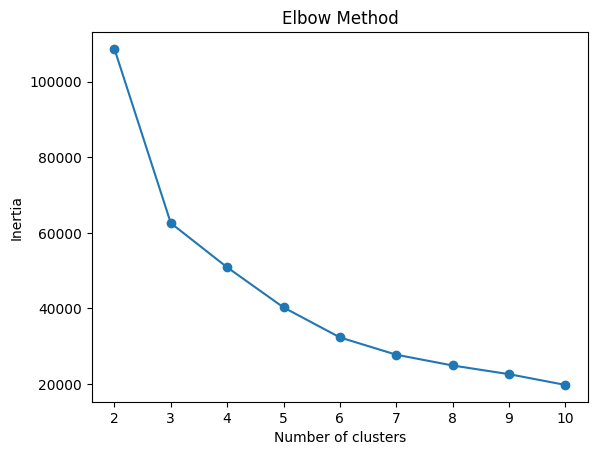

In [7]:
inertia = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


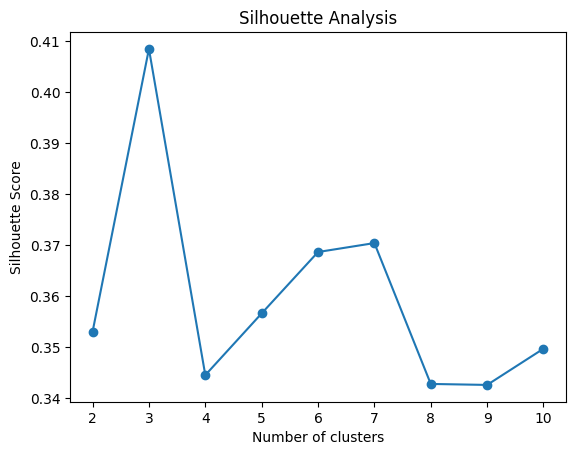

In [8]:
silhouette_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

plt.plot(K, silhouette_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

rfm_clean["segment"] = clusters


C:\Users\Asus\AppData\Local\Temp\ipykernel_33540\328188858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_clean["segment"] = clusters


In [10]:
cluster_profile = rfm_clean.groupby("segment").agg(
    avg_recency=("recency", "mean"),
    avg_frequency=("frequency", "mean"),
    avg_monetary=("monetary", "mean"),
    customers=("recency", "count")
).reset_index()

cluster_profile


,segment,avg_recency,avg_frequency,avg_monetary,customers
0,0,459.779919,1.0,97.696766,17330
1,1,83.492131,1.0,91.193524,25099
2,2,218.803280,1.0,233.618530,16892
3,3,253.416646,1.0,75.109727,24510


In [11]:
segment_map = {
    0: "High-Value Loyalists",
    1: "At-Risk Churners",
    2: "New Customers",
    3: "Occasional Buyers"
}

rfm_clean["segment_name"] = rfm_clean["segment"].map(segment_map)


C:\Users\Asus\AppData\Local\Temp\ipykernel_33540\1322695814.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_clean["segment_name"] = rfm_clean["segment"].map(segment_map)


In [12]:
df_ltv = df.merge(
    rfm_clean[["recency", "frequency", "monetary", "segment_name"]],
    on=["recency", "frequency", "monetary"],
    how="inner"
)

df_ltv["historical_ltv"] = df_ltv["total_spend"]


In [13]:
df_ltv["predicted_ltv"] = (
    df_ltv["avg_order_value"] *
    df_ltv["orders_per_month"] *
    12
)


In [14]:
segment_ltv = df_ltv.groupby("segment_name").agg(
    avg_ltv=("historical_ltv", "mean"),
    avg_predicted_ltv=("predicted_ltv", "mean"),
    customers=("customer_unique_id", "count")
)

segment_ltv


,avg_ltv,avg_predicted_ltv,customers
segment_name,,,
At-Risk Churners,91.237057,1094.844687,28881
High-Value Loyalists,96.718486,1160.621828,18952
New Customers,231.973094,2783.677133,17926
Occasional Buyers,74.557204,894.686444,29324


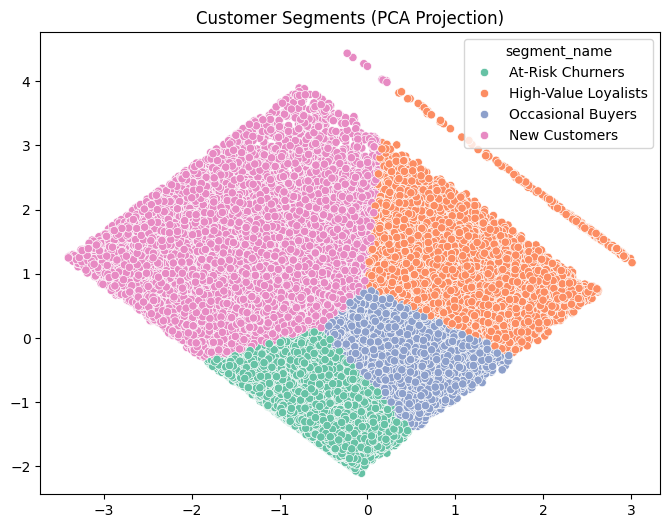

In [15]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_data[:,0],
    y=pca_data[:,1],
    hue=rfm_clean["segment_name"],
    palette="Set2"
)
plt.title("Customer Segments (PCA Projection)")
plt.show()


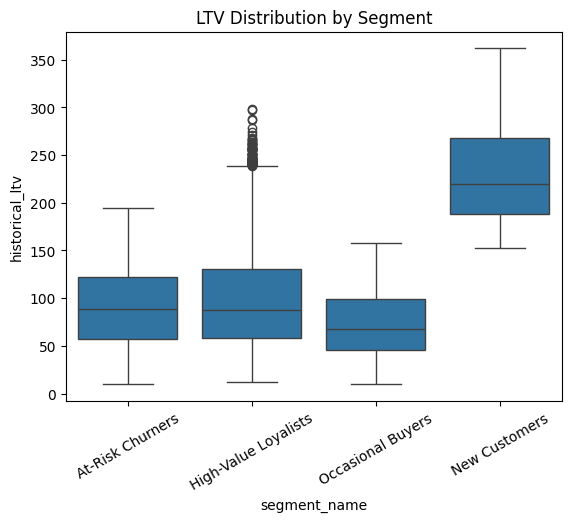

In [16]:
sns.boxplot(
    data=df_ltv,
    x="segment_name",
    y="historical_ltv"
)
plt.xticks(rotation=30)
plt.title("LTV Distribution by Segment")
plt.show()


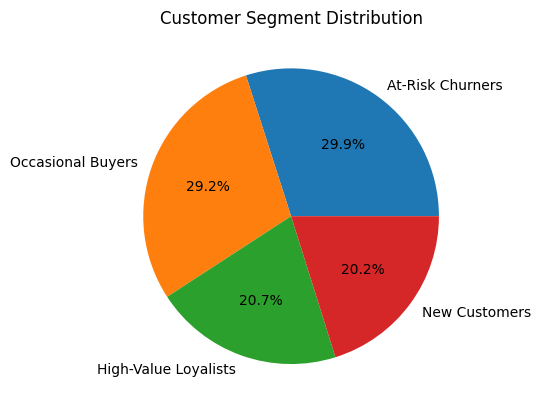

In [17]:
rfm_clean["segment_name"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Customer Segment Distribution")
plt.ylabel("")
plt.show()


In [18]:
import sys
import os

# Get the absolute path of the current notebook
notebook_path = os.path.abspath("")
print(notebook_path)

e:\SKILLS\customer-analytics-ecommerce-azure\notebooks


In [ ]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.dirname(current_dir)

if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.segmentation import save_model

save_model(kmeans, "../models/kmeans_segmentation.pkl")
save_model(scaler, "../models/rfm_scaler.pkl")


In [20]:
rfm_clean.to_parquet("../data/silver/customer_segments.parquet", index=False)
